In [161]:
# Import packages
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
import os
import dill, sys
import copy
import numpy as np
import matplotlib.pyplot as plt

import kuaizi as kz
from kuaizi.display import display_single, SEG_CMAP, display_scarlet_results_tigress
from kuaizi.detection import Data

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, Row, vstack
from astropy.coordinates import SkyCoord

from scipy.stats import binned_statistic_2d

In [19]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)
kz.set_matplotlib(style='JL', usetex=True, dpi=100, fontsize=16)

### Mock objects distribution

In [165]:
obj_cat = Table.read('./Catalog/mock_sample/mock_obj_cat_0_5000.fits')[0:5000]
obj_cat['SB_eff_avg'] = (obj_cat['mags'] + 2.5 * np.log10(2 * np.pi * obj_cat['sersic_rhalf_circ']**2)[:, None])
# params_cat = Table.read('./Catalog/mock_sample/mock_gal_param_truth_0_5000.fits')[0:5000]

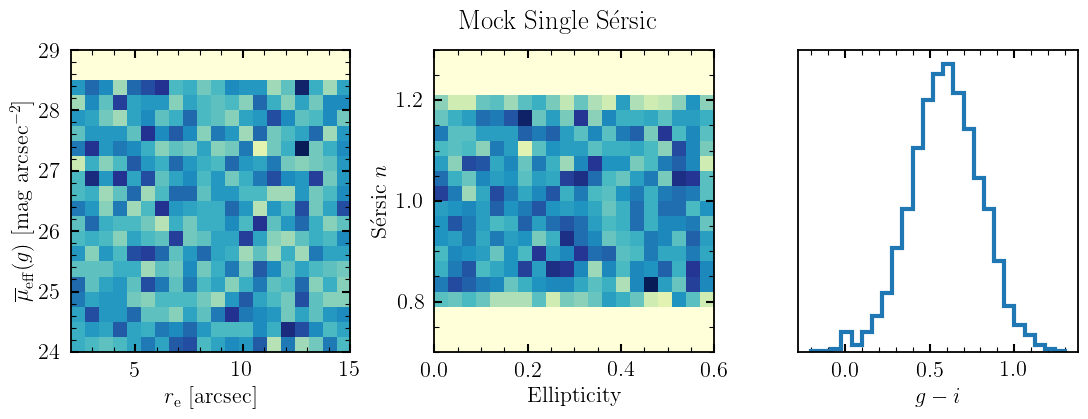

In [166]:
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(13, 4))

bin_num = [20, 20]
_range = [[2, 15], [24, 29]]
_extent = [item for sublist in _range for item in sublist]

res_truth = binned_statistic_2d(
    obj_cat['sersic_rhalf_circ'].data,
    obj_cat['SB_eff_avg'].data[:, 0],
    None,
    statistic='count',
    bins=bin_num,
    range=_range,
    )
ax1.imshow(res_truth.statistic.T,
           extent=_extent,
           aspect='auto', cmap='YlGnBu')
ax1.set_xlabel(r'$r_{\rm e}$ [arcsec]')
ax1.set_ylabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$]')


bin_num = [20, 20]
_range = [[0, 0.6], [0.7, 1.3]]
_extent = [item for sublist in _range for item in sublist]

res_truth = binned_statistic_2d(
    obj_cat['sersic_ell'].data,
    obj_cat['sersic_n'].data,
    None,
    statistic='count',
    bins=bin_num,
    range=_range,
    )
ax2.imshow(res_truth.statistic.T,
           extent=_extent,
           aspect='auto', cmap='YlGnBu')
ax2.set_ylabel(r"S\'ersic $n$")
ax2.set_xlabel(r'Ellipticity')


ax3.hist(obj_cat['SB_eff_avg'][:, 0] - obj_cat['SB_eff_avg'][:, 2],
         histtype='step', lw=3, range=(-0.2, 1.3), bins=25)
ax3.set_xlabel('$g-i$')
ax3.set_yticks([])

fig.suptitle(r'Mock Single S\'ersic')

plt.subplots_adjust(wspace=0.3)

### Vanilla scarlet

In [167]:
method = 'vanilla'
files = [
    f'./Catalog/mock_sample/{method}/_lsbg_meas_{method}_monotonic_{method}_{start*500}_{start*500+500}_nosegmap.fits' 
    for start in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
]
meas_cat = vstack([Table.read(file) for file in files])
meas_cat['rhalf_circularized'] *= 0.168

Text(0.5, 0.93, 'Vanilla scarlet')

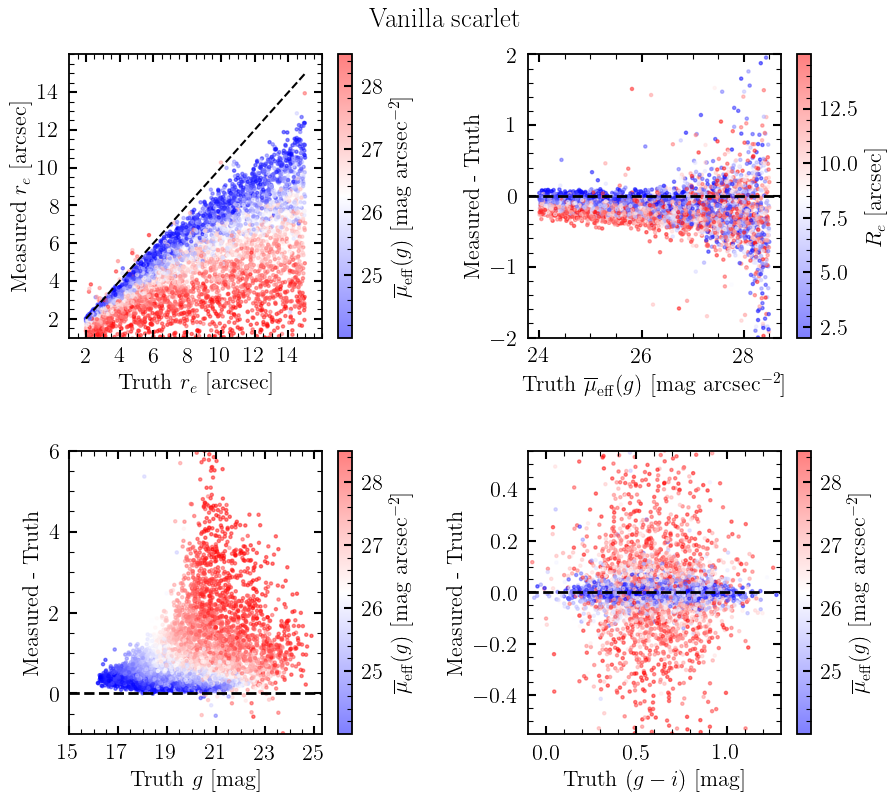

In [168]:
fig, axes = plt.subplots(2, 2, figsize=(10, 9))

# compare R_e
plt.sca(axes[0, 0])
plt.scatter(obj_cat['sersic_rhalf_circ'], 
            meas_cat['rhalf_circularized'], 
            c=obj_cat['SB_eff_avg'][:, 0], 
            cmap='bwr',
            s=5, alpha=0.5)
x = np.linspace(2, 15, 10)
plt.plot(x, x, '--', color='k')
# plt.plot(x, x + 1, '--')
# plt.plot(x, x - 1, '--')

plt.xticks(ticks=np.arange(2, 15, 2))
plt.yticks(ticks=np.arange(2, 15, 2))
plt.colorbar(label=r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$]')
plt.xlabel(r'Truth $r_e$ [arcsec]')
plt.ylabel(r'Measured $r_e$ [arcsec]')
plt.xlim(1, 16)
plt.ylim(1, 16)

# compare SB_eff
plt.sca(axes[0, 1])

plt.scatter(obj_cat['SB_eff_avg'][:, 0], 
            meas_cat['SB_eff_avg'][:, 0] - obj_cat['SB_eff_avg'][:, 0], 
            c=obj_cat['sersic_rhalf_circ'], s=5, alpha=0.5, cmap='bwr')

plt.axhline(0, ls='--', color='k', lw=2)
plt.colorbar(label=r'$R_e$ [arcsec]')
plt.xticks(ticks=np.arange(24, 29, 2))
plt.xlabel(r'Truth $\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$]')
plt.ylabel(r'Measured - Truth')
plt.ylim(-2, 2)


# Compare total magnitude
plt.sca(axes[1, 0])
plt.scatter(obj_cat['mags'][:, 0], 
            meas_cat['mag'][:, 0] - obj_cat['mags'][:, 0], 
            c=obj_cat['SB_eff_avg'][:, 0], 
            s=5, alpha=0.5, cmap='bwr')
plt.axhline(0, ls='--', color='k', lw=2)
plt.colorbar(label=r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$]')
plt.xticks(ticks=np.arange(15, 26, 2))
plt.xlabel(r'Truth $g$ [mag]')
plt.ylabel(r'Measured - Truth')

plt.ylim(-1, 6)


plt.sca(axes[1, 1])
gi_truth = obj_cat['mags'][:, 0] - obj_cat['mags'][:, 2]
gi_meas = meas_cat['mag'][:, 0] - meas_cat['mag'][:, 2]
plt.scatter(gi_truth, gi_meas - gi_truth,
            c=obj_cat['SB_eff_avg'][:, 0], 
            s=5, alpha=0.5, cmap='bwr')
plt.axhline(0, ls='--', color='k', lw=2)
plt.colorbar(label=r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$]')
# plt.xticks(ticks=np.arange(15, 26, 2))
plt.xlabel(r'Truth $(g-i)$ [mag]')
plt.ylabel(r'Measured - Truth')

plt.xlim(-0.1, 1.3)
plt.ylim(-0.55, 0.55)

plt.subplots_adjust(wspace=0.45, hspace=0.4)
plt.suptitle('Vanilla scarlet', y=0.93)

### Spergel scarlet

In [169]:
method = 'spergel'
files = [
    f'./Catalog/mock_sample/{method}/_lsbg_meas_{method}_monotonic_{method}_{start*500}_{start*500+500}_nosegmap.fits' 
    for start in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
]
meas_cat = vstack([Table.read(file) for file in files])
meas_cat['rhalf_circularized'] *= 0.168

Text(0.5, 0.93, 'Spergel scarlet')

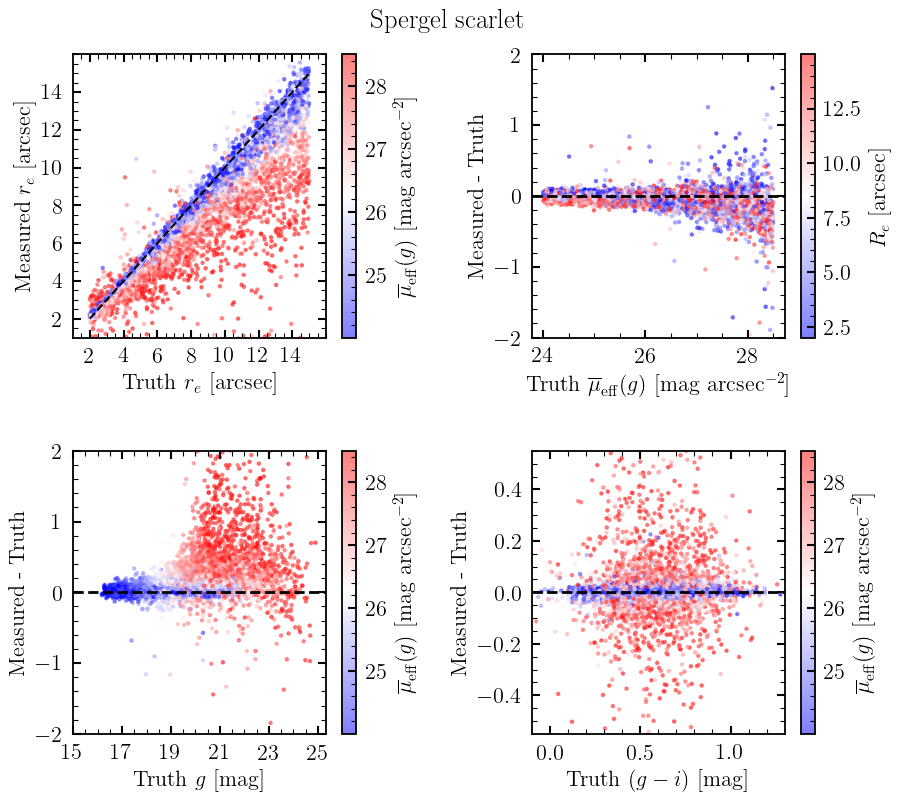

In [170]:
fig, axes = plt.subplots(2, 2, figsize=(10, 9))

# compare R_e
plt.sca(axes[0, 0])
plt.scatter(obj_cat['sersic_rhalf_circ'], 
            meas_cat['rhalf_circularized'], 
            c=obj_cat['SB_eff_avg'][:, 0], 
            cmap='bwr',
            s=5, alpha=0.5)
x = np.linspace(2, 15, 10)
plt.plot(x, x, '--', color='k')
# plt.plot(x, x + 1, '--')
# plt.plot(x, x - 1, '--')

plt.xticks(ticks=np.arange(2, 15, 2))
plt.yticks(ticks=np.arange(2, 15, 2))
plt.colorbar(label=r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$]')
plt.xlabel(r'Truth $r_e$ [arcsec]')
plt.ylabel(r'Measured $r_e$ [arcsec]')
plt.xlim(1, 16)
plt.ylim(1, 16)

# compare SB_eff
plt.sca(axes[0, 1])

plt.scatter(obj_cat['SB_eff_avg'][:, 0], 
            meas_cat['SB_eff_avg'][:, 0] - obj_cat['SB_eff_avg'][:, 0], 
            c=obj_cat['sersic_rhalf_circ'], s=5, alpha=0.5, cmap='bwr')

plt.axhline(0, ls='--', color='k', lw=2)
plt.colorbar(label=r'$R_e$ [arcsec]')
plt.xticks(ticks=np.arange(24, 29, 2))
plt.xlabel(r'Truth $\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$]')
plt.ylabel(r'Measured - Truth')
plt.ylim(-2, 2)


# Compare total magnitude
plt.sca(axes[1, 0])
plt.scatter(obj_cat['mags'][:, 0], 
            meas_cat['mag'][:, 0] - obj_cat['mags'][:, 0], 
            c=obj_cat['SB_eff_avg'][:, 0], 
            s=5, alpha=0.5, cmap='bwr')
plt.axhline(0, ls='--', color='k', lw=2)
plt.colorbar(label=r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$]')
plt.xticks(ticks=np.arange(15, 26, 2))
plt.xlabel(r'Truth $g$ [mag]')
plt.ylabel(r'Measured - Truth')

plt.ylim(-2, 2)


plt.sca(axes[1, 1])
gi_truth = obj_cat['mags'][:, 0] - obj_cat['mags'][:, 2]
gi_meas = meas_cat['mag'][:, 0] - meas_cat['mag'][:, 2]
plt.scatter(gi_truth, gi_meas - gi_truth,
            c=obj_cat['SB_eff_avg'][:, 0], 
            s=5, alpha=0.5, cmap='bwr')
plt.axhline(0, ls='--', color='k', lw=2)
plt.colorbar(label=r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$]')
# plt.xticks(ticks=np.arange(15, 26, 2))
plt.xlabel(r'Truth $(g-i)$ [mag]')
plt.ylabel(r'Measured - Truth')

plt.xlim(-0.1, 1.3)
plt.ylim(-0.55, 0.55)

plt.subplots_adjust(wspace=0.45, hspace=0.4)
plt.suptitle('Spergel scarlet', y=0.93)

### Wavelet (monotonic)

In [157]:
# method = 'wavelet'
# files = [
#     f'./Catalog/mock_sample/min_grad_-002/_lsbg_meas_{method}_monotonic_{method}_{start*500}_{start*500+500}_nosegmap.fits' 
#     for start in [0, 1, 2, 3]
# ]
# meas_cat = vstack([Table.read(file) for file in files])
# meas_cat['rhalf_circularized'] *= 0.168

In [187]:
obj_cat = Table.read('./Catalog/mock_sample/mock_obj_cat_0_5000.fits')[0:5000]
obj_cat['SB_eff_avg'] = (obj_cat['mags'] + 2.5 * np.log10(2 * np.pi * obj_cat['sersic_rhalf_circ']**2)[:, None])
# params_cat = Table.read('./Catalog/mock_sample/mock_gal_param_truth_0_5000.fits')[0:5000]

In [188]:
method = 'wavelet'
files = [
    f'./Catalog/mock_sample/wavelet/_lsbg_meas_{method}_monotonic_{method}_{start*500}_{start*500+500}_nosegmap.fits' 
    for start in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
]
meas_cat = vstack([Table.read(file) for file in files])
meas_cat['rhalf_circularized'] *= 0.168

Text(0.5, 0.93, 'Monotonic Wavelet scarlet')

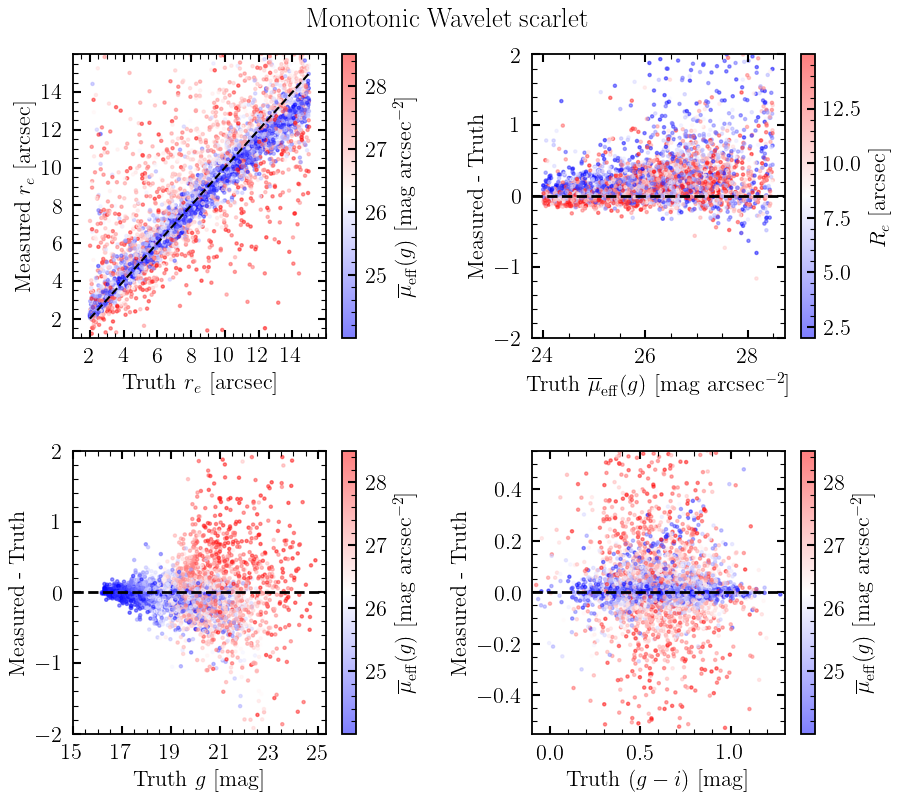

In [190]:
fig, axes = plt.subplots(2, 2, figsize=(10, 9))

# compare R_e
plt.sca(axes[0, 0])
plt.scatter(obj_cat['sersic_rhalf_circ'], 
            meas_cat['rhalf_circularized'], 
            c=obj_cat['SB_eff_avg'][:, 0], 
            cmap='bwr',
            s=5, alpha=0.5)
x = np.linspace(2, 15, 10)
plt.plot(x, x, '--', color='k')
# plt.plot(x, x + 1, '--')
# plt.plot(x, x - 1, '--')

plt.xticks(ticks=np.arange(2, 15, 2))
plt.yticks(ticks=np.arange(2, 15, 2))
plt.colorbar(label=r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$]')
plt.xlabel(r'Truth $r_e$ [arcsec]')
plt.ylabel(r'Measured $r_e$ [arcsec]')
plt.xlim(1, 16)
plt.ylim(1, 16)

# compare SB_eff
plt.sca(axes[0, 1])

plt.scatter(obj_cat['SB_eff_avg'][:, 0], 
            meas_cat['SB_eff_avg'][:, 0] - obj_cat['SB_eff_avg'][:, 0], 
            c=obj_cat['sersic_rhalf_circ'], s=5, alpha=0.5, cmap='bwr')

plt.axhline(0, ls='--', color='k', lw=2)
plt.colorbar(label=r'$R_e$ [arcsec]')
plt.xticks(ticks=np.arange(24, 29, 2))
plt.xlabel(r'Truth $\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$]')
plt.ylabel(r'Measured - Truth')
plt.ylim(-2, 2)


# Compare total magnitude
plt.sca(axes[1, 0])
plt.scatter(obj_cat['mags'][:, 0], 
            meas_cat['mag'][:, 0] - obj_cat['mags'][:, 0], 
            c=obj_cat['SB_eff_avg'][:, 0], 
            s=5, alpha=0.5, cmap='bwr')
plt.axhline(0, ls='--', color='k', lw=2)
plt.colorbar(label=r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$]')
plt.xticks(ticks=np.arange(15, 26, 2))
plt.xlabel(r'Truth $g$ [mag]')
plt.ylabel(r'Measured - Truth')

plt.ylim(-2, 2)


plt.sca(axes[1, 1])
gi_truth = obj_cat['mags'][:, 0] - obj_cat['mags'][:, 2]
gi_meas = meas_cat['mag'][:, 0] - meas_cat['mag'][:, 2]
plt.scatter(gi_truth, gi_meas - gi_truth,
            c=obj_cat['SB_eff_avg'][:, 0], 
            s=5, alpha=0.5, cmap='bwr')
plt.axhline(0, ls='--', color='k', lw=2)
plt.colorbar(label=r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$]')
# plt.xticks(ticks=np.arange(15, 26, 2))
plt.xlabel(r'Truth $(g-i)$ [mag]')
plt.ylabel(r'Measured - Truth')

plt.xlim(-0.1, 1.3)
plt.ylim(-0.55, 0.55)

plt.subplots_adjust(wspace=0.45, hspace=0.4)
plt.suptitle('Monotonic Wavelet scarlet', y=0.93)